# Importing and Installing libraries

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.81 MiB | 30.70 MiB/s, done.
Resolving deltas: 100% (577/577), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/li

In [2]:
import os,sys
import pandas as pd
from PIL import Image
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
import numpy as np

ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from matplotlib import pyplot
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [3]:
class PedDataset(Dataset):
    def load_dataset(self, dataset_dir='../input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed', mode='train'):
        self.add_class('dataset',1,'pedestrian')
        images_dir = dataset_dir + '/PNGImages/'
        annotations_dir = dataset_dir + '/Annotation/'
        masks_dir = dataset_dir + '/PedMasks/'
        if mode=='train':
            j=0
            for filename in listdir(images_dir):
                j+=1
                if j>150:
                    continue
                image_id = filename
                img_path = images_dir + image_id
                ann_path = annotations_dir + image_id[:-4]+'.txt'
                mask_path = masks_dir + image_id[:-4]+'_mask.png'
                self.add_image('dataset', image_id=image_id, path=img_path, ann_path=ann_path, mask_path=mask_path)
        if mode=='test':
            j=0
            for filename in listdir(images_dir):
                j+=1
                if j<=150:
                    continue
                image_id = filename
                img_path = images_dir + image_id
                ann_path = annotations_dir + image_id[:-4]+'.txt'
                mask_path = masks_dir + image_id[:-4]+'_mask.png'
                self.add_image('dataset', image_id=image_id, path=img_path, ann_path=ann_path, mask_path=mask_path)
        
    def extract_boxes(self, image_id):
        info = self.image_info[image_id]
        file = info['ann_path']
        boxes = list()
        f = open(filename,'r')
        for x in f:
            if '(Xmin, Ymin) - (Xmax, Ymax)' in x:
                xmin = int(x[-23:-20])
                ymin = int(x[-18:-15])
                xmax = int(x[-10:-7])
                ymax = int(x[-5:-2])
                coors = [xmin, ymin, xmax, ymax]
                boxes.append(coors)
        width = 559
        height = 536
        return boxes, width, height
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        file = info['mask_path']
        #boxes, w, h = self.extract_boxes(image_id)
        #masks = zeros([w, h, len(boxes)], dtype='uint8')
        masks = Image.open(file)
        masks = np.array(masks)
        ob_id = np.unique(masks)
        ob_id = ob_id[1:]
        masks = masks == ob_id[:, None, None]
        masks = np.moveaxis(masks,0,-1)
        class_ids = list()
        for i in range(len(ob_id)):
#             box = boxes[i]
#             row_s, row_e = box[1], box[3]
#             col_s, col_e = box[0], box[2]
#             masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('pedestrian'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [4]:
train_set = PedDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
test_set = PedDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 150
Test: 20


(353, 623, 3)
(353, 623, 3)


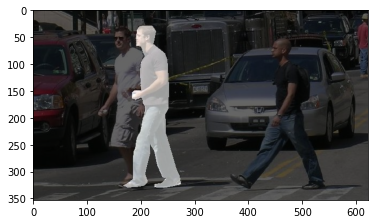

In [5]:
image_id = 2
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
pyplot.imshow(image)
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.6)
pyplot.show()

# Training

In [6]:
class PedConfig(Config):
    NAME = "ped_cfg"
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 150
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 448
    
config = PedConfig()

In [7]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [8]:
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [9]:
model.load_weights('../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [10]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./ped_cfg20210527T1846/mask_rcnn_ped_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrc

# Evaluation

In [11]:
class PredictionConfig(Config):
    NAME = "ped_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

In [12]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

In [13]:
for i in listdir():
    print(i)
    if i[:3]=='ped':
        path=i

__notebook__.ipynb
ped_cfg20210527T1846
Mask_RCNN


In [14]:
model.load_weights('./'+path+'/mask_rcnn_ped_cfg_0010.h5', by_name=True)

Re-starting from epoch 10


In [15]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    j=0
    for image_id in dataset.image_ids:
        if j>50:
            continue
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
        j+=1
    mAP = mean(APs)
    return mAP

In [16]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.971
Test mAP: 0.998


Processing 1 images
image                    shape: (487, 493, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


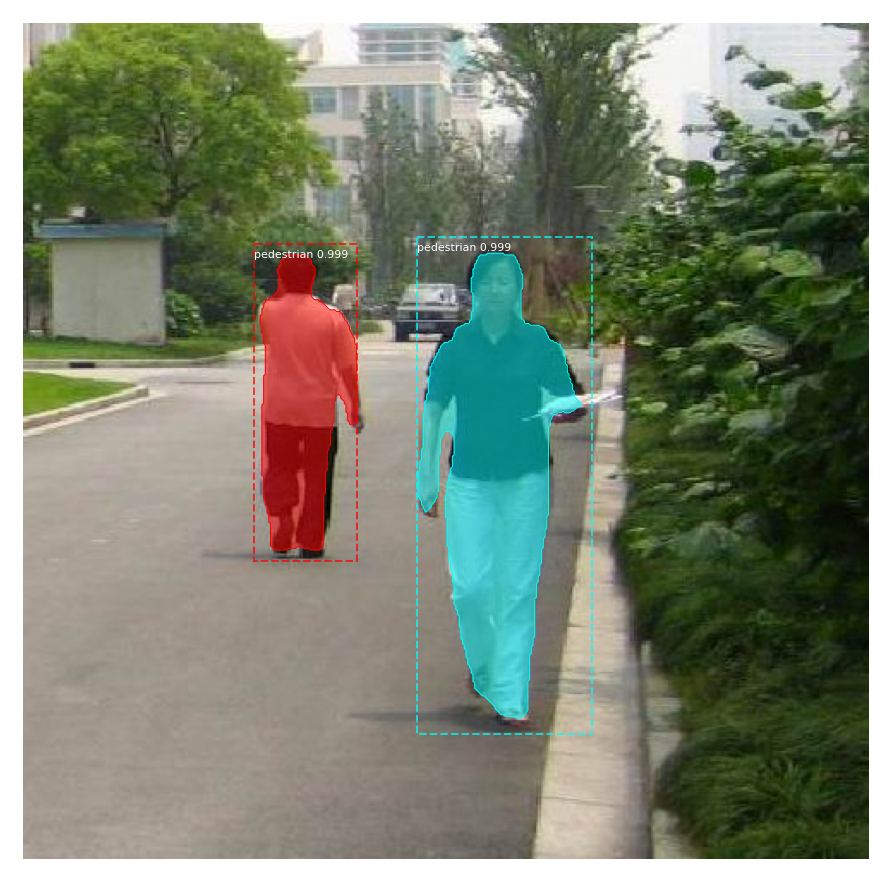

Processing 1 images
image                    shape: (501, 448, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


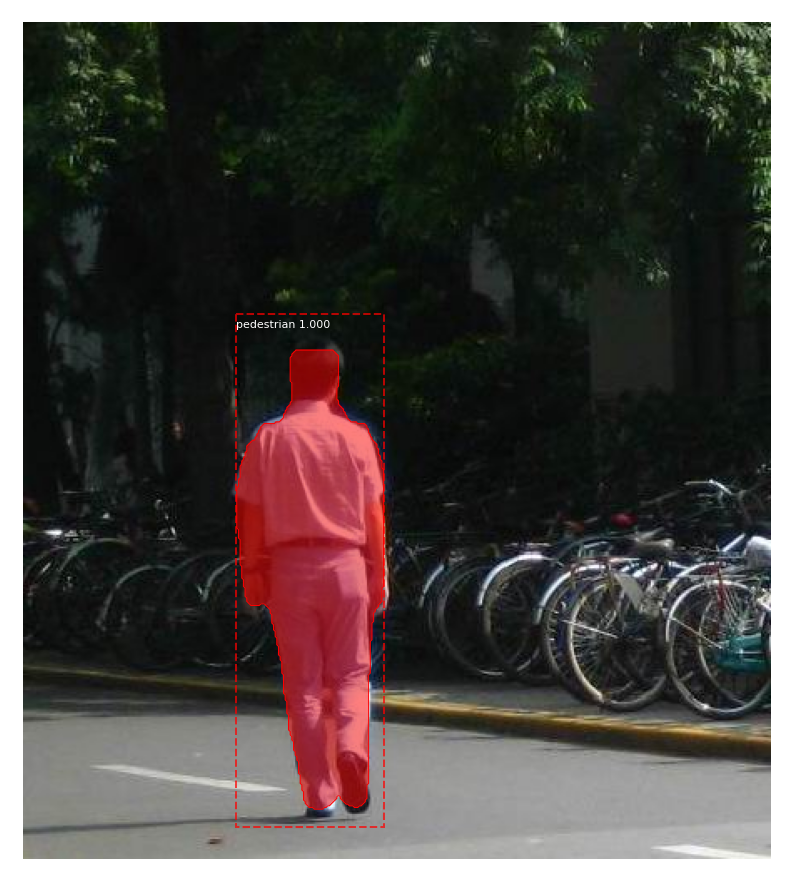

Processing 1 images
image                    shape: (420, 459, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


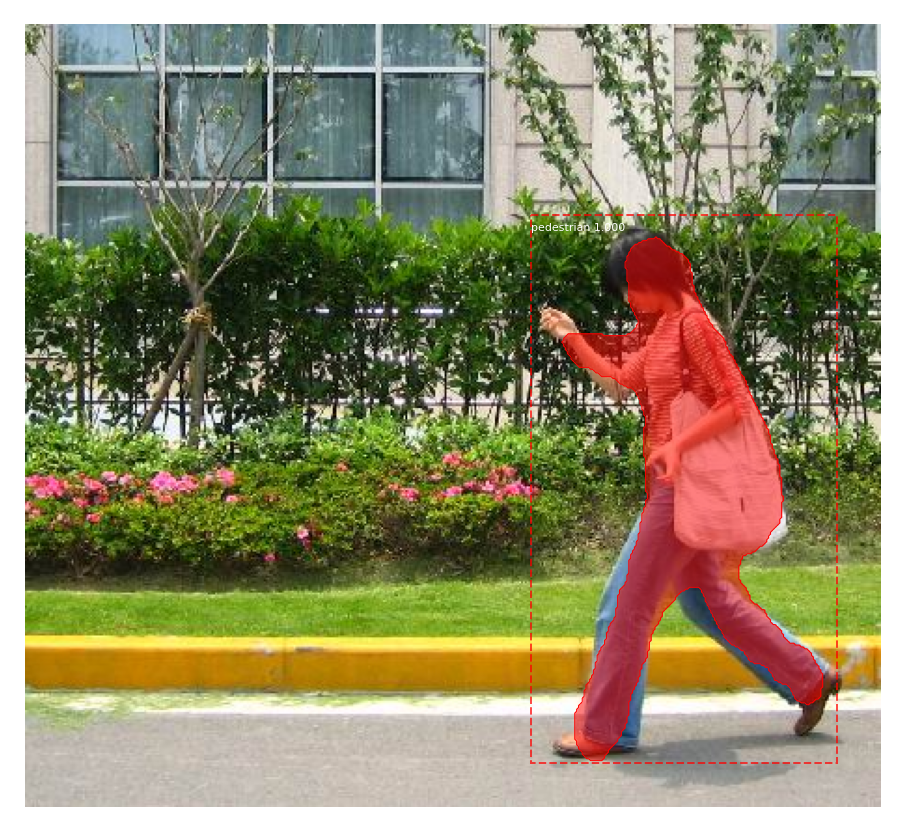

Processing 1 images
image                    shape: (348, 473, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


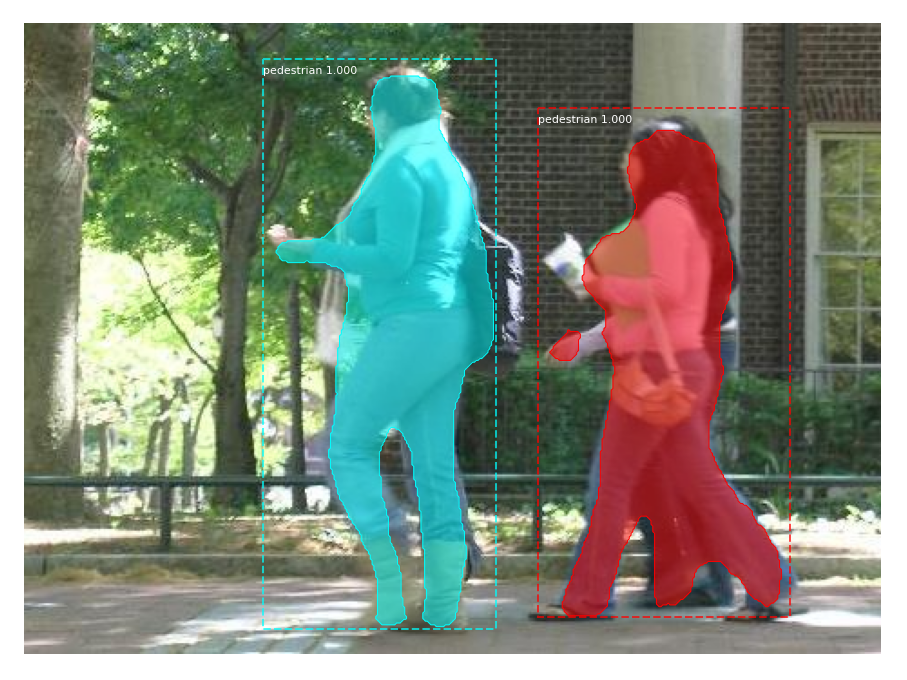

Processing 1 images
image                    shape: (379, 354, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


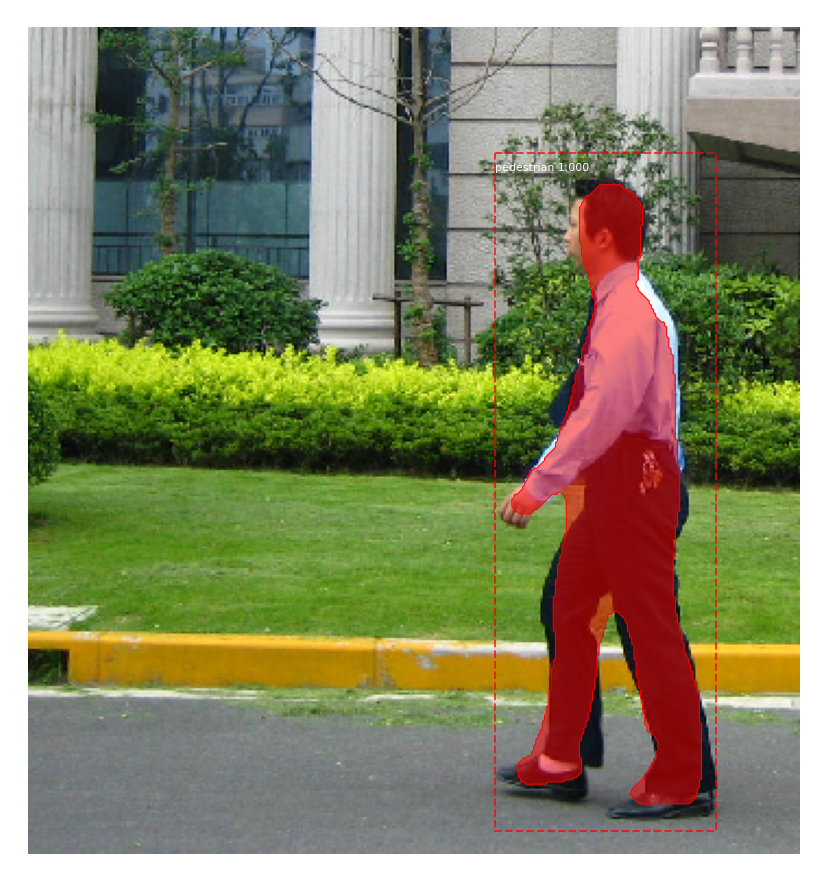

In [17]:
class_names = ['BG', 'pedestrian']
for i in range(5):
    image = test_set.load_image(i)
    results = model.detect([image], verbose=1)
    r = results[0]
    display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])